In [1]:
import torch, torchvision
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 0 to use
torch.cuda.current_device()

0

In [3]:
import random
import torch.backends.cudnn as cudnn
import numpy as np

def seed_fix(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    np.random.seed(seed)
    
SEED = 23
seed_fix(SEED) 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# 기존 코드와 동일한 부분
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS = 100
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# CIFAR-10 데이터셋을 불러옴
trainset = datasets.CIFAR10(
    root='./.data/',
    train=True,
    download=True,
    transform=transform
)
testset = datasets.CIFAR10(
    root='./.data/',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# 모델 아키텍처는 그대로 유지
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 256)  # CIFAR-10 이미지 크기는 32x32x3 (컬러 이미지)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # CIFAR-10 클래스 수는 10

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # 입력 이미지 크기에 맞게 조정
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 훈련 및 테스트 손실을 저장할 리스트 생성
train_losses = []
test_losses = []

# train 및 evaluate 함수는 그대로 사용
def train(model, train_loader, optimizer):
    running_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
    return running_loss

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

# Loss curve를 그리기 위한 리스트 생성
train_losses = []
test_losses = []

# 에폭(epoch)별로 학습 및 테스트 수행
best_acc = 0
best_loss = 1e9
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    running_loss = train(model, train_loader, optimizer)
    epoch_loss = running_loss / len(train_loader.dataset)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    # 훈련 및 테스트 손실 기록
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_acc = test_accuracy
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))


Files already downloaded and verified
Files already downloaded and verified
[1] Test Loss: 1.8513, Accuracy: 35.05%
[2] Test Loss: 1.6894, Accuracy: 40.64%
[3] Test Loss: 1.6085, Accuracy: 43.47%
[4] Test Loss: 1.5539, Accuracy: 45.33%
[5] Test Loss: 1.5160, Accuracy: 47.05%
[6] Test Loss: 1.4864, Accuracy: 48.07%
[7] Test Loss: 1.4550, Accuracy: 48.75%
[8] Test Loss: 1.4204, Accuracy: 50.70%
[9] Test Loss: 1.3966, Accuracy: 50.94%
[10] Test Loss: 1.3959, Accuracy: 51.26%
[11] Test Loss: 1.4003, Accuracy: 50.64%
[12] Test Loss: 1.3855, Accuracy: 51.32%
[13] Test Loss: 1.3502, Accuracy: 52.55%
[14] Test Loss: 1.3944, Accuracy: 51.05%
[15] Test Loss: 1.3490, Accuracy: 52.72%
[16] Test Loss: 1.3597, Accuracy: 52.26%
[17] Test Loss: 1.3450, Accuracy: 52.64%
[18] Test Loss: 1.3668, Accuracy: 52.02%
[19] Test Loss: 1.3730, Accuracy: 51.87%
[20] Test Loss: 1.3964, Accuracy: 51.71%
[21] Test Loss: 1.3556, Accuracy: 53.00%
[22] Test Loss: 1.4196, Accuracy: 52.09%
[23] Test Loss: 1.3829, Accurac

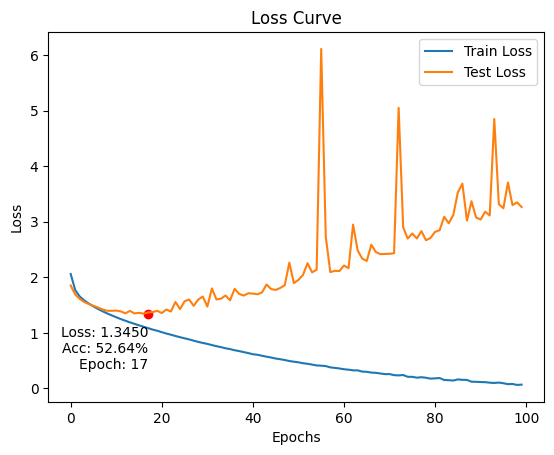

In [9]:

# Loss curve를 그림
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Loss가 가장 작은 지점에 빨간 점을 찍고 주석을 추가
plt.scatter(best_epoch, best_loss, color='red', marker='o')
plt.annotate(f'Loss: {best_loss:.4f}\nAcc: {best_acc:.2f}%\nEpoch: {best_epoch}', (best_epoch, best_loss), textcoords="offset points", xytext=(0, -40), ha='right')

plt.savefig('./plot/dnn_loss_curve.png')

In [10]:
torch.save(model.state_dict(), './save_weights/dnn.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('fc1.weight', tensor([[-0.0545, -0.0370, -0.0154,  ..., -0.0301, -0.0193, -0.0716],
        [-0.0286, -0.0473, -0.0364,  ...,  0.0239, -0.0053,  0.0127],
        [-0.0188,  0.0008,  0.0050,  ...,  0.0117, -0.0034, -0.0241],
        ...,
        [-0.0384, -0.0417, -0.0369,  ...,  0.0422,  0.0242, -0.0225],
        [ 0.0324,  0.0137,  0.0306,  ...,  0.0498,  0.0553,  0.0422],
        [ 0.0474,  0.0254,  0.0316,  ...,  0.0225,  0.0087,  0.0233]],
       device='cuda:0')), ('fc1.bias', tensor([ 2.1832e-01, -1.9539e-01, -6.4625e-02,  1.1044e-01, -1.4439e-01,
        -2.1359e-01, -1.4351e-02, -1.4216e-01, -3.4525e-02,  2.3096e-02,
        -7.5087e-02,  5.4764e-02, -6.7174e-03, -3.2661e-02,  9.7450e-02,
        -8.8917e-02, -8.7839e-02,  1.6102e-02, -2.0317e-04, -6.4305e-02,
         6.5994e-02, -7.7110e-02, -1.8171e-01,  1.7849e-02,  4.8611e-02,
        -3.5048e-03, -5.6684e-03,  2.1128e-01, -1.3516e-01, -1.7599e-02,
         6.6470e-02, -3.7433e

In [11]:
load_model = Net().to(DEVICE)
load_model.load_state_dict(torch.load('./save_weights/dnn.pt'))

<All keys matched successfully>

In [12]:
load_model.eval()

Net(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)